In [1]:
# TO DO: 1) set up cross-validate, RF and NN loops
# 2) check out datasets from atpworldtour's API

In [ ]:
# stratified makes sure the proportion of y-classes is consistent across splits;
# probably not necessary for a dataset with ~8000 matches

In [1]:
## TO DO: make use of gridsearchCV and StratifiedKfold, set up model assessment loop
## (to do this, you have to read the docs on RF, SVM, NN, etc.)

## then, try these out with a neural net etc because there is probably a non-linear relationship
## (ie you gain more win-probability from 3 games needed to 1 vs 5 to 3)

## then, try adding interaction terms, for example sets_won/sets_lost and service breaks

## also add features of Aces, double faults
##
## Eventually: you set up cross validation that randomly selects 80% of the data to train on

import numpy as np
import math
import time
import pandas as pd
from sklearn.metrics import log_loss
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold


#df_pred = pd.read_csv('feature_df_7_3.csv')
df_pred = pd.read_csv('feature_df_pbp3_7_13.csv')
del df_pred['Unnamed: 0'] #; del df_pred['score']
df_pred['sv_points_pct_0'] = np.nan_to_num(np.divide(df_pred['p0_swp'],df_pred['p0_sp'].astype('float')))
df_pred['sv_points_pct_1'] = np.nan_to_num(np.divide(df_pred['p1_swp'],df_pred['p1_sp'].astype('float')))

# apply feature scaling to the term 'elo_diff' (mean is close to and should be approx. 0
# so doesn't subtract mean)
sd = np.std(df_pred['elo_diff'])
df_pred['elo_diff'] = [a/sd for a in df_pred['elo_diff']]

/Users/jacobgollub/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide
/Users/jacobgollub/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


In [2]:
# behold, this is 1000s of times faster than list comprehension, for an array of size ~1,000,000
c = int(max(df_pred['match_id'])*.8)
start = time.clock()
np.array(df_pred['match_id'])>c
print time.clock() - start

0.007187


In [3]:
val_df = df_pred[df_pred['match_id']<=c]

In [4]:
def in_dict(x,d):
    return x in d

In [33]:
# function to cross-validate, with no match-overlap between splits (since there are 100-200
# points per match)
def cross_validate(val_df,clf,cols,target,hyper_parameters,n_trials):
    print 'fitting model...'
    ids = list(set(val_df['match_id']))
    vfunc = np.vectorize(in_dict)
    kfold = KFold(n_splits=n_trials,shuffle=True)
    key = hyper_parameters.keys()[0]
    scores = [[] for k in range(len(hyper_parameters[key]))]
    
    for train_index,____ in kfold.split(ids):
        train_dict = dict(zip(train_index,[1]*len(train_index)))
        train_ind = vfunc(np.array(val_df['match_id']),train_dict)
        test_ind = (1 - train_ind)==1
        Xtrain, ytrain = val_df[cols][train_ind], val_df[target][train_ind]
        Xtest, ytest = val_df[cols][test_ind], val_df[target][test_ind]
        
        # retrieve classification score for every hyper_parameter fed into this function
        for j in xrange(len(hyper_parameters[key])):
            setattr(clf,key,hyper_parameters[key][j])
            clf.fit(Xtrain,ytrain)
            score = clf.score(Xtest,ytest)
            scores[j].append(score)
    for i in range(len(scores)):
        print hyper_parameters[key][i],': ',np.mean(scores[i])
    best_ind = np.argmax([np.mean(a) for a in scores])
    return hyper_parameters[key][best_ind]

In [34]:
clf=linear_model.LogisticRegression(fit_intercept = True)
cols = ['in_lead','elo_diff']
h_params = {'C':[.0001,.001,.01,.1,1,10,100,1000]}
cross_validate(val_df,clf,cols,'winner',h_params,n_trials=5)

fitting model...
0.0001 :  0.732423193016
0.001 :  0.736505459184
0.01 :  0.736202259887
0.1 :  0.735942636664
1 :  0.73593071245
10 :  0.73593071245
100 :  0.73593071245
1000 :  0.73593071245


0.001

In [25]:
clf = linear_model.LogisticRegression(fit_intercept = True)
setattr(clf,"C",3.0)
clf

LogisticRegression(C=3.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
# form train and test as 80-20 split; keeps matches in their entirety separate from one another
# implemented this because groupkfold was throwing me errors...
ids = list(set(val_df['match_id']))
vfunc = np.vectorize(in_dict)

n_trials = 5
clf = linear_model.LogisticRegression(fit_intercept = True)
cols = ['in_lead','elo_diff']
target = 'winner'

# turn on shuffle to randomize; convert training "ids" to training indices
# for some reason, [true,true,true] is the required format for mask; not [1,1,1], 
# which kills the kernel; hence, the ==1 in test_ind
kfold = KFold(n_splits=n_trials,shuffle=True)
scores = []

for train_index,____ in kfold.split(ids):
    train_dict = dict(zip(train_index,[1]*len(train_index)))
    train_ind = vfunc(np.array(val_df['match_id']),train_dict)
    test_ind = (1 - train_ind)==1
    Xtrain, ytrain = val_df[cols][train_ind], val_df[target][train_ind]
    Xtest, ytest = val_df[cols][test_ind], val_df[target][test_ind]
    
    clf.fit(Xtrain,ytrain)
    score = clf.score(Xtest,ytest)
    scores.append(score)
    break
    
#     Xtrain, ytrain = val_df[cols][train_ind], val_df[target][train_ind]
#     Xtest, ytest = val_df[cols][test_ind], val_df[target][test_ind]
    
#     print 'hi'
#     clf.fit(Xtrain,ytrain)
#     score = clf.score(Xtest,ytest)
#     scores.append(score)
#     break


    
# train_ids = np.random.choice(ids,size=int(.8*len(ids)),replace=False)
# train_dict = dict(zip(train_ids,[1]*len(train_ids)))
# df_pred['train'] = [1 if df_pred['match_id'][i] in train_dict else 0 for i in xrange(len(df_pred))]
# mask = df_pred['train']
# mask = mask==1

In [14]:
scores

[0.73123011439038221]

In [ ]:
train_ind = train_ind+1-1
val_df[train_ind]

In [ ]:
#Xtrain, ytrain = val_df[cols][train_ind], val_df[target][train_ind]
Xtest, ytest = val_df[cols][test_ind], val_df[target][test_ind]

In [ ]:
from sklearn.model_selection import StratifiedKFold
# feed in validation set, return model with most favorable hyper-parameters
h_param = {'C':[.0001,.001,.01,.1,1,10,100,1000]}
def cross_validate(X,Y,clf,hyper_parameters):
    print 'fitting model...'
    skf = StratifiedKFold(n_splits=5)
    for train_index,test_index in skf.split(X,Y):
        X_train,X_test = X[train_index],X[test_index]
        Y_train,Y_test = Y[train_index],Y[test_index]
        
        

In [82]:
# to do: set up another notebook with solely cross-validation framework and model testing...
# test hyperparameters for these sklearn models

#set_features = ['0','1','01','10']
cols = []
scores = ['sets_0','sets_1','games_0','games_1','points_0','points_1']
break_feats = [u'up_break_point', u'down_break_point', u'break_adv']
point_rates = [u'sv_points_pct_0', u'sv_points_pct_1',u'tp_0',u'tp_1']

#cols.append(['in_lead'])
#cols.append(['in_lead','elo_diff'])
#cols.append(['elo_diff']+scores+point_rates)
cols.append(['elo_diff','sets_0','sets_1','points_0','points_1','break_adv']+point_rates)
cols.append(['in_lead','elo_diff']+scores+break_feats+point_rates)

#models.append(ensemble.RandomForestClassifier(n_estimators=200,max_features=None,oob_score=True))

models = [linear_model.LogisticRegression(fit_intercept = True)]

for col in cols:
    print 'cols: ',col
    for model in models:
        Xtrain = df_pred[mask][col]; Xtest = df_pred[~mask][col]
        clf = model
        clf.fit(Xtrain,ytrain)
        
        # cross-validate the model, fitting hyper-params on training set
        #clf = cross_validate(Xtrain,ytrain,model)

        probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
        train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
        train_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)  
        print 'classifier: ', str(clf).split("(")[0]
        print train_loss, test_loss
        print train_accuracy, test_accuracy
    print '\n'

cols:  ['elo_diff', 'sets_0', 'sets_1', 'points_0', 'points_1', 'break_adv', u'sv_points_pct_0', u'sv_points_pct_1', u'tp_0', u'tp_1']


NameError: name 'cross_validate' is not defined

In [94]:
models = [MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)]

for col in cols:
    print 'cols: ',col
    for model in models:
        Xtrain = df_pred[mask][col]; Xtest = df_pred[~mask][col]
        clf = model
        clf.fit(Xtrain,ytrain)

        probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
        train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
        train_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)  
        print 'classifier: ', str(clf).split("(")[0]
        print train_loss, test_loss
        print train_accuracy, test_accuracy
    print '\n'

cols:  ['in_lead']
classifier:  MLPClassifier
0.592070675275 0.587870933464
0.720698931729 0.725649718518


cols:  ['in_lead', 'elo_diff']
classifier:  MLPClassifier
0.533870735215 0.540941704104
0.73950770561 0.738641867244


cols:  ['elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1', u'sv_points_pct_0', u'sv_points_pct_1', u'tp_0', u'tp_1']
classifier:  MLPClassifier
0.509678675955 0.520507065748
0.749804487894 0.738766279065


cols:  ['elo_diff', 'sets_0', 'sets_1', 'points_0', 'points_1', 'break_adv', u'sv_points_pct_0', u'sv_points_pct_1', u'tp_0', u'tp_1']
classifier:  MLPClassifier
0.489414662259 0.499000124495
0.757770969593 0.751011956865


cols:  ['in_lead', 'elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1', u'up_break_point', u'down_break_point', u'break_adv', u'sv_points_pct_0', u'sv_points_pct_1', u'tp_0', u'tp_1']
classifier:  MLPClassifier
0.484273282366 0.493234694394
0.762665845761 0.756677137995




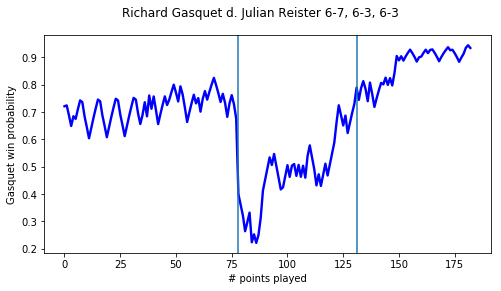

In [82]:
# graphically, try to compare different probabilities of different models

import matplotlib.pyplot as plt
%matplotlib inline

probs = np.concatenate((probs_train[:,0],probs_test[:,0]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==0]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),1-m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Gasquet win probability')
ax.set_xlabel('# points played')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
plt.savefig('gasquet_reister_7_14_all_features')
fig.show()

In [ ]:
# current feedback is that the drop in probability is probably a little too great from 
# end of first set to beginning of second
# this is something that should eventually be fixed with markov/hierarchical models

In [ ]:
cols1 = ['elo_diff']
cols2 = ['elo_diff','set_diff']
cols3 = ['elo_diff','set_diff','game_diff']
cols = ['elo_diff','set_diff','game_diff','point_diff']

# either change do-classify to work for all classifiers or use this code
# repeat this for random forest, neural net, adaboost, etc
print 'features: ', cols
clf = ensemble.RandomForestClassifier(n_estimators=10,max_features=None,oob_score=True)
clf=clf.fit(Xtrain, ytrain)
probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
train_accuracy = clf.oob_score_
#test_accuracy = clf.oob_score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (train_accuracy)
print "Log Loss on training data: %0.2f" % (train_loss)
#print "Accuracy on test data:     %0.2f" % (test_accuracy)
print "Log Loss on test data:     %0.2f" % (test_loss)

In [ ]:
# next, 1) compare avg log_loss for prediction with sets, games, and points as features
# 2) then try keeping track of service breaks as a feature
# 3) the next step: does order matter?
# see your notes for next steps

probs = clflogELO.predict_proba(Xtest)
log_loss(ytest,probs,labels=[0,1])

In [7]:
# features for number of sets away from the match
# number of games away from the set
# number of points away from set
# then observe the gasquet match graph and see if this fixes anything
# df_pred['p0_sets_away'] = [2-int(a[1]) for a in df_pred['set_score']]
# df_pred['p1_sets_away'] = [2-int(a[4]) for a in df_pred['set_score']]
# df_pred['p0_games_away'] = [6-int(a[1]) if int(a[4])<5 else 7-int(a[1]) for a in df_pred['game_score']]
# df_pred['p1_games_away'] = [6-int(a[4]) if int(a[1])<5 else 7-int(a[4]) for a in df_pred['game_score']]

# points away...

#####################

# form train and test as 80-20 split; keeps matches in their entirety separate from one another
# takes about 40 seconds

# train_ids = np.random.choice(ids,size=int(.8*len(ids)),replace=False)
# train_dict = dict(zip(train_ids,[1]*len(train_ids)))
# df_pred['train'] = [1 if df_pred['match_id'][i] in train_dict else 0 for i in xrange(len(df_pred))]
# mask = df_pred['train']
# mask = mask==1